In [133]:
import pandas as pd
import numpy as np
import re


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 150)

import warnings
warnings.filterwarnings(action='ignore')

In [111]:
data = pd.read_csv('./gurgaon_properties_cleaned_v1.csv')
data.head()

- area with type
- agePossession
- facing
- furnishDetails
- features

### areawithType

In [11]:
data['areaWithType'][:10]

In [37]:
get_super_builtup_area("Plot area 173(144.65 sq.m.)Built Up area: 1415 sq.yards (1183.12 sq.m.)Carpet area: 1350 sq.yards (1128.77 sq.m.)")

In [45]:
get_super_builtup_area("Super Built up area 1950(181.16 sq.m.)")

In [43]:
match = re.search("Super Built up area (\d+\.?\d*)", "Super Built up area 1950(181.16 sq.m.)")
match.group(1)

In [49]:
def get_super_builtup_area(text):
    match = re.search("Super Built up area (\d+\.?\d*)", text)
    if match:
        return match.group(1)

In [68]:
# this functions extracts carpet area and built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [52]:
# this checks if area in sq.m is provided and if not, it converts area in sq m to sq.ft

def convert_area_to_sqft(text, area_value):
    if area_value is None:
        return None
    
    match = re.search("{area_value} \((\d+\.?\d*) sq.m.\)", text)
    if match:
        sq_m_value = float(match.group(1))
        return 10.7369 * sq_m_value
    return area_value

In [ ]:
convert_area_to_sqft("Built Up area: 160 (14.86 sq.m.)")

In [112]:
data['super_built_up_area'] = data['areaWithType'].apply(get_super_builtup_area)
data['super_built_up_area'] = data.apply(lambda x: convert_area_to_sqft(x['areaWithType'] , x['super_built_up_area']), axis=1)

data['built_up_area'] = data['areaWithType'].apply(lambda x : get_area(x, "Built Up area"))
data['built_up_area'] = data.apply(lambda x: convert_area_to_sqft(x['areaWithType'] , x['built_up_area']), axis=1)

data['carpet_area'] = data['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
data['carpet_area'] = data.apply(lambda x: convert_area_to_sqft(x['areaWithType'] , x['carpet_area']), axis=1)


In [64]:
data[['areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']]

In [32]:
data['areaWithType'][21]

In [113]:
all_nan_df = data[data['super_built_up_area'].isnull() & data['built_up_area'].isnull() & data['carpet_area'].isnull()]
all_nan_df_index = all_nan_df.index

# all_nan_df is a dataframe where super builtup area, built up area and carpet area all are none

In [78]:
all_nan_df[['property_type','areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']]

In [108]:
def extract_plot_area(text):
    match = re.search(r"Plot area (\d+\.?\d*)", text)
    return float(match.group(1)) if match else None
        

In [134]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(lambda x: extract_plot_area(x))

In [135]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area'] / row['built_up_area']) == 9:    # built_up_area is in square yards
            return 9 * row['built_up_area']
        elif round(row['area']/row['built_up_area']) == 11:
            return 10.7 * row['built_up_area']
        else:
            return row['built_up_area']

In [136]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale, axis=1)

In [137]:
data.update(all_nan_df)

In [120]:
data.sample(2)

# additionalRoom

In [152]:
unique_room_categories =  data['additionalRoom'].value_counts().index
lst = []

for i in unique_room_categories:
    if len(i.split(',')) > 1:
        for j in i.split(','):
            lst.append(j)
    else:
        lst.append(i)

In [151]:
len(unique_room_categories[0].split(','))

In [154]:
len(lst)

In [155]:
set(lst)

There are 6 Unique kinds of additional rooms:
1. pooja room
2. servant room
3. store room
4. study room
5. others
6. not available

In [188]:
data['additionalRoom'] = data['additionalRoom'].str.lower()
temp = data[~data['additionalRoom'].isnull()]

In [207]:
new_cols = ['pooja room', 'store room' , 'servant room' , 'study room', 'others']

for col in new_cols:
    data[col] = data['additionalRoom'].str.contains(col).astype(float)

In [160]:
data['additionalRoom'].isnull().sum()

In [201]:
data.drop(columns=['store_room','others','servant_room','pooja_room', 'study_room'], inplace=True)

In [208]:
data.head()

# agePossession

In [209]:
data['agePossession'].value_counts()

- major categories are:
1. by [month] 2023/2024/2025/2026/2027/2028
2. undefined
3. 0 to 1 year old
4. 1 to 5 year old
5. 5 to 10 year old
6. 10+ year old
7. under construction
8. within 3 months
9. within 6 months

In [221]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if value == 'within 3 months' or value == 'within 6 months' or value == '0 to 1 year old':
        return "new"
    if value == '1 to 5 year old':
        return "relatively new"
    if value == '5 to 10 year old':
        return "moderately old"
    if value == '10+ year old':
        return "old"
    if  value == 'undefined':
        return "undefined"
    if "under construction" in value or "by" in value :
        return "Under construction"
    
    else:
        try:
            if int(value.split(' ')[-1]):
                return "Under construction"
        except:
            "Undefined"

In [218]:
data['agePossession'] = data['agePossession'].str.strip().str.lower()

In [215]:
categorize_age_possession('May 2024')

In [211]:
int("May 2023".split(' ')[-1])

In [222]:
data['agePossession'][:10]

In [224]:
data['agePossession'] = data['agePossession'].apply(categorize_age_possession)

In [227]:
data.sample(10)

,property_type,property_name,sector,society,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,address,floorNum,facing,agePossession,nearbyLocations,description,furnishDetails,features,rating,super_built_up_area,built_up_area,carpet_area,pooja room,store room,servant room,study room,others
3031,flat,3 BHK Flat in Sector 113 Gurgaon,sector 113,la vida by tata housing,1.90,18500.0,1027.0,Super Built up area 1579(146.69 sq.m.)Carpet area: 1027 sq.ft. (95.41 sq.m.),3.0,2.0,2,pooja room,"Middle, Sector 113 Gurgaon , Gurgaon, Haryana",10.0,North-East,relatively new,"['Dwarka Sector 21', 'Pacific D21 Mall', 'Bajghera Road', 'Dwarka Expy', 'Euro International School, Sector- 109.', 'The NorthCap University', ""Ri...","This beautiful 3 bhk flat in sector 113 gurgaon is situated in la vida by tata housing, one of the popular residential society in gurgaon. The fla...","['2 Wardrobe', '1 Water Purifier', '3 Fan', '2 Geyser', '1 Stove', '8 Light', '2 AC', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No Bed', 'N...","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Fac...",NaN,1579,NaN,1027.00,1.0,0.0,0.0,0.0,0.0
157,house,2 Bedroom House for sale in Jacobpura,jacobpura,jacob pura,0.35,9722.0,360.0,Built Up area: 360 (33.45 sq.m.),2.0,1.0,0,NaN,"15/3, Jacobpura, Jacobpura, Gurgaon, Haryana",NaN,NaN,old,NaN,Independece house for sale in jacobpura near kabir bhawan gurgaon,[],NaN,"['Environment3 out of 5', 'Lifestyle4 out of 5', 'Connectivity5 out of 5', 'Safety4 out of 5']",None,360.0,NaN,NaN,NaN,NaN,NaN,NaN
2375,flat,2 BHK Flat in Sector 107 Gurgaon,sector 107,m3m woodshire,1.02,6649.0,1534.0,Super Built up area 1534(142.51 sq.m.),2.0,2.0,3,study room,"N/a, Sector 107 Gurgaon, Gurgaon, Haryana",6.0,North-East,relatively new,"['Signum 107', 'Nora Solomon Medicenter', 'Indira Gandhi International Airport', 'The Shikshiyan School', 'Najafgarh Jheel Bird Sanctuary', 'Skyla...",Looking for a 2 bhk property for sale in gurgaon? Buy this 2 bhk flat in m3m woodshire that is situated in sector 107 gurgaon. This residential fl...,[],"['Security / Fire Alarm', 'Power Back-up', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', '...","['Green Area4.5 out of 5', 'Construction5 out of 5', 'Management4.5 out of 5', 'Amenities5 out of 5', 'Connectivity4 out of 5']",1534,NaN,NaN,0.0,0.0,0.0,1.0,0.0
3060,flat,3 BHK Flat in Sector 109 Gurgaon,sector 109,ats kocoon,2.20,10023.0,2195.0,Super Built up area 2095(194.63 sq.m.)Built Up area: 1860 sq.ft. (172.8 sq.m.),3.0,4.0,3,servant room,"Sector 109 Gurgaon, Gurgaon, Haryana",8.0,North-East,relatively new,"['Jagdish Super Market', 'Dwarka', 'Euro International School', 'Gyaananda School', 'SCR Model School', 'Radha Krishan Mandir', 'ICICI BANK ATM, A...",Ats kocoon is one of gurgaon's most sought after destination for apartments and this 3 bhk flat in sector 109 gurgaon is your opportunity to be a ...,"['7 Fan', '1 Exhaust Fan', '8 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Modular Kitchen', 'No Mi...","['Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance St...","['Green Area5 out of 5', 'Construction5 out of 5', 'Management5 out of 5', 'Amenities5 out of 5', 'Connectivity4 out of 5']",2095,1860.0,NaN,0.0,0.0,1.0,0.0,0.0
254,flat,3 BHK Flat in Sector 83 Gurgaon,sector 83,vatika gurgaon,1.08,6224.0,1735.0,Super Built up area 1735(161.19 sq.m.),3.0,3.0,2,others,"C123, Sector 83 Gurgaon, Gurgaon, Haryana",11.0,North-East,relatively new,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec...","Located in the popular residential address of sector 83 gurgaon, vatika gurgaon 21 is one of the most preferred destinat

# furnishDetails

In [231]:
data['furnishDetails'].value_counts()

[]                                                                                                                                                                                                                                                                       441
['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']     214
['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']      75
['1 Wardrobe', '1 Fan', '1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa'

In [262]:
all_furnishings = []

for i in data['furnishDetails'].dropna():
    lst = list(set(i.replace('[', '').replace(']', '').replace("'","").replace("'","").split(' ')))
    all_furnishings.extend(lst)

all_furnishings = [item.strip().lower() for item in all_furnishings]
unique_furnishing = list(set(all_furnishings))

In [259]:
re.sub(r"(\d+)", '', 'hello 345')

'hello '

In [273]:
# remove empty strings, numbers from unique_furnishing

# remove numbers
unique_furnishing = [re.sub(r"(\d+)", '', i) for i in unique_furnishing]

# remove empty strings and "no"
for i in unique_furnishing:
    if i == "" or i=="no":
        unique_furnishing.remove(i)


In [246]:
data['furnishDetails'][0]

"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']"

In [274]:
unique_furnishing

['light',
 'sofa,',
 'chimney,',
 'fridge',
 'machine',
 'bed,',
 'curtains,',
 'washing',
 'wardrobe,',
 'tv',
 'purifier',
 'kitchen',
 'exhaust',
 'light,',
 'wardrobe',
 'machine,',
 'stove,',
 'tv,',
 'bed',
 'dining',
 'microwave',
 'microwave,',
 'stove',
 'table',
 'fan,',
 'water',
 'ac,',
 'kitchen,',
 'purifier,',
 'geyser,',
 'curtains',
 'modular',
 'fridge,',
 'table,',
 'sofa',
 'ac']

In [ ]:
for key, i in enumerate(unique_furnishing):
    print(key,i)

- in unique furnishings , there are some repeated values like "ac" and "ac," , 

1. light
2. sofa
3. chimney
4. fridge
5. machine
6. bed
7. curtains
8. washing
9. wardrobe
10. tv
11. purifier
12. kitchen
13. exhaust
14. wardrobe
15. stove
16. bed
17. dining 
18. microwave
19. fan
20. table
21. water
22. ac
23. kitchen
24. geyser
25. modular


-- combining words like "modular" and "kitchen" , "water" and "purifier" because they make more sense together

1. light
2. sofa
3. chimney
4. fridge
5. washing machine
6. bed
7. curtains
8. wardrobe
9. tv
10. water purifier
11. exhaust fan
12. fan
13. stove
14. microwave
15. ac
16. geyser
17. modular kitchen
18. fan

In [398]:
data['furnishDetails'] = data['furnishDetails'].str.lower()

In [449]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in data['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    data[furnishing] = data['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = data[['furnishDetails'] + columns_to_include]

In [450]:
data.head()

,property_type,property_name,sector,society,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,address,floorNum,facing,agePossession,nearbyLocations,description,furnishDetails,features,rating,super_built_up_area,built_up_area,carpet_area,pooja room,store room,servant room,study room,others,no exhaust fan,wardrobe,dining table,no modular kitchen,tv,light,no washing machine,no fridge,no water purifier,no ac,washing machine,water purifier,no light,no wardrobe,no tv,fridge,no curtains,fan,bed,no bed,modular kitchen,curtains,no chimney,microwave,no fan,no sofa,no microwave,stove,no dining table,exhaust fan,geyser,no stove,sofa,no geyser,chimney,ac
0,house,2 Bedroom House for sale in Laxman Vihar,laxman vihar,independent,1.25,78125.0,160.0,Built Up area: 160 (14.86 sq.m.),2.0,3.0,0,NaN,"Laxman Vihar, Sector 3a, Laxman Vihar, Gurgaon, Haryana",1.0,NaN,undefined,"['Chintapurni Mandir', 'Sheetla Mata Mandir', 'State bank ATM', 'Prateek Nursing Home And Polyclinic', 'Sneh Hospital Gurgaon', 'Dr. Hitesh Dawar'...",Best in class property available at laxman vihar location in gurgaon,"['1 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geyser', 'no modular kitchen', 'no ...",NaN,"['Environment4 out of 5', 'Lifestyle4 out of 5', 'Connectivity5 out of 5', 'Safety4 out of 5']",None,160.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,house,3 Bedroom House for sale in Sector 52 Gurgaon,sector 52,ardee city,2.25,16071.0,1400.0,Plot area 2160(200.67 sq.m.)Built Up area: 1800 sq.ft. (167.23 sq.m.)Carpet area: 1400 sq.ft. (130.06 sq.m.),3.0,3.0,3,servant room,"Upper First Floor, Sector 52 Gurgaon, Gurgaon, Haryana",4.0,South-East,new,"['Hanuman Mandir', 'New Life Church', 'Radhakrishna Shani Mandir', 'Hdfc ATM', 'Standard chartered ATM', 'Hdfc bank ATM', 'Icici ATM', 'Citi bank ...","Brand new 3bhk independent upper first floor on sale ardee city sector 52 gurgaon, excellent interior with fixture and fitting. Good location, nea...","['3 wardrobe', '7 fan', '1 exhaust fan', '3 geyser', '1 stove', '15 light', '1 chimney', '1 modular kitchen', 'no ac', 'no bed', 'no curtains', 'n...","['Private Garden / Terrace', 'Maintenance Staff', 'Visitor Parking']","['Environment4 out of 5', 'Safety4 out of 5', 'Lifestyle5 out of 5', 'Connectivity5 out of 5']",None,1800.0,1400.0,0.0,0.0,1.0,0.0,0.0,0,3,1,0,1,15,1,1,1,1,1,1,0,0,1,1,1,7,1,1,1,1,0,1,0,1,1,1,1,1,3,0,1,0,1,1
2,flat,3 BHK Flat in Sector 37D Gurgaon,sector 37d,signature global city,1.25,6082.0,2055.0,Carpet area: 2055 (190.92 sq.m.),3.0,3.0,3,not available,"Sector 37D Gurgaon, Gurgaon, Haryana",4.0,NaN,Under construction,"['Sapphire 83 Mall Sector 83', 'Dwarka Expressway', 'Pataudi Road', 'NH-8 Delhi Jaipur Highway', 'DPGITM Engineering College Sector 34', 'Genesis ...",It's a very beautiful property with amazing location .Having a full terrace on jt.,"['1 modular kitchen', '1 chimney', '4 ac', 'no bed', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geyser', 'no light', 'no mi...","['Power Back-up', 'Lift(s)', 'Swimming Pool', 'Fitness Centre / GYM', 'Club house / Community Center']","['Environment4 out of 5', 'Lifestyle4 out of 5', 'Connectivity4 out of 5', 'Safety4 out of 5']",None,NaN,2055.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,4
3,house,4 Bedroom House for sale in Palam Vihar,palam vihar,ansal api spanish court,2.90,18626.0,1557.0,Plot area 173(144.65 sq.m.)Built Up area: 1415 sq.yards (1183.12 sq.m.)Carpet area: 1350 sq.yards (1128.77 sq.m.),4.0,4.0,3,store room,"A, Block Ansals Palam Vihar, Palam Vihar, Gurgaon, Haryana",2.0,North,relatively new,"['Palam Vihar Vyapar kendra', 'Palam triangle', 'HUDA Sector 23 Market', 'Ram Mandir', 'Sheetla Mata Mandir', 'Kalyan Hospital Gurgaon', ""DR KAPOO...",On sale 173 sq yrds built up house park facing. 2. Bedroom attach bathroom plus dine dining mod

#### Categorizing furnishDetails as furnished, semi-furnished or unfurnished using KMeans

In [446]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [452]:
furnishings_df.head()

,furnishDetails,no exhaust fan,wardrobe,dining table,no modular kitchen,tv,light,no washing machine,no fridge,no water purifier,no ac,washing machine,water purifier,no light,no wardrobe,no tv,fridge,no curtains,fan,bed,no bed,modular kitchen,curtains,no chimney,microwave,no fan,no sofa,no microwave,stove,no dining table,exhaust fan,geyser,no stove,sofa,no geyser,chimney,ac
0,"['1 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geyser', 'no modular kitchen', 'no ...",1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,"['3 wardrobe', '7 fan', '1 exhaust fan', '3 geyser', '1 stove', '15 light', '1 chimney', '1 modular kitchen', 'no ac', 'no bed', 'no curtains', 'n...",0,3,1,0,1,15,1,1,1,1,1,1,0,0,1,1,1,7,1,1,1,1,0,1,0,1,1,1,1,1,3,0,1,0,1,1
2,"['1 modular kitchen', '1 chimney', '4 ac', 'no bed', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geyser', 'no light', 'no mi...",1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,4
3,"['4 wardrobe', '10 fan', '1 exhaust fan', '2 geyser', '9 light', '1 modular kitchen', '1 curtains', 'no ac', 'no bed', 'no chimney', 'no dining ta...",0,4,1,0,1,9,1,1,1,1,1,1,0,0,1,1,0,10,1,1,1,1,1,1,0,1,1,1,1,1,2,1,1,0,1,1
4,"['2 wardrobe', '3 fan', '1 exhaust fan', '3 geyser', '3 light', '3 ac', '1 modular kitchen', '1 chimney', 'no bed', 'no curtains', 'no dining tabl...",0,2,1,0,1,3,1,1,1,0,1,1,0,0,1,1,1,3,1,1,1,1,0,1,0,1,1,1,1,1,3,1,1,0,1,3


In [454]:
# features scaling
scaler=  StandardScaler()
scaled_data= scaler.fit_transform(furnishings_df.iloc[:,1:])

In [457]:
wcss_reduced = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

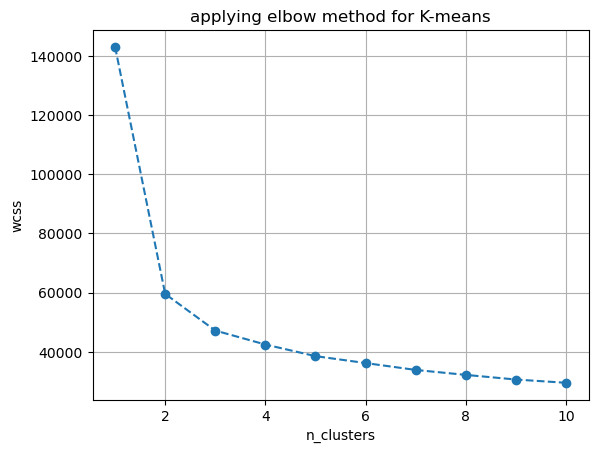

In [461]:
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('applying elbow method for K-means')
plt.xlabel('n_clusters')
plt.ylabel('wcss')
plt.grid()

In [463]:
n_clusters=3

# fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# making the predictions
cluster_assignments = kmeans.predict(scaled_data)

In [469]:
data['furnishing_type'] = cluster_assignments

# 0 -> unfurnished
# 1-> semi-furnished
# 2 -> furnished

In [472]:
data[['furnishDetails', 'furnishing_type']][:5]

,furnishDetails,furnishing_type
0,"['1 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geyser', 'no modular kitchen', 'no ...",1
1,"['3 wardrobe', '7 fan', '1 exhaust fan', '3 geyser', '1 stove', '15 light', '1 chimney', '1 modular kitchen', 'no ac', 'no bed', 'no curtains', 'n...",2
2,"['1 modular kitchen', '1 chimney', '4 ac', 'no bed', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geyser', 'no light', 'no mi...",1
3,"['4 wardrobe', '10 fan', '1 exhaust fan', '2 geyser', '9 light', '1 modular kitchen', '1 curtains', 'no ac', 'no bed', 'no chimney', 'no dining ta...",2
4,"['2 wardrobe', '3 fan', '1 exhaust fan', '3 geyser', '3 light', '3 ac', '1 modular kitchen', '1 chimney', 'no bed', 'no curtains', 'no dining tabl...",2


## Features

In [476]:
data[['society', 'features']][:10]

,society,features
0,independent,NaN
1,ardee city,"['Private Garden / Terrace', 'Maintenance Staff', 'Visitor Parking']"
2,signature global city,"['Power Back-up', 'Lift(s)', 'Swimming Pool', 'Fitness Centre / GYM', 'Club house / Community Center']"
3,ansal api spanish court,"['Feng Shui / Vaastu Compliant', 'Maintenance Staff', 'Water Storage', 'No open drainage around', 'Park', 'Visitor Parking', 'Security Personnel',..."
4,smart world gems,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Piped-gas', 'Visi..."
5,godrej aria,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor P..."
6,emaar mgf marbella,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling..."
7,signature global park,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Water Stora..."
8,unitech uniworld resorts,"['Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'Separate entry for servant room', 'No open drainage around', 'Park', 'Vi..."
9,sare homes,NaN


In [477]:
data['features'].isnull().sum()

710

- now, in the features column, we have 710 null values.
- we have another csv file whihc has data about apartments and the societies they are in
- we can merge the two dataframes, adn fill otu the null values in features column in our data from the details about societies in the apartments dataframe

In [480]:
app_df = pd.read_csv('./apartments.csv')
app_df.head()

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '...",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_t...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km',...",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4...","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"
2,Adani Brahma Samsara Vilasa,"Land, 3, 4 BHK Independent Floor in Sector 63, Gurgaon","['AIPL Business Club Sector 62', 'Heritage Xperiential Learning School', 'CK Birla Hospital', 'Paras Trinity Mall Sector 63', 'Rapid Metro Station...","{'AIPL Business Club Sector 62': '2.7 Km', 'Heritage Xperiential Learning School': '2 Km', 'CK Birla Hospital': '2.5 Km', 'Paras Trinity Mall Sect...",https://www.99acres.com/adani-brahma-samsara-vilasa-sector-63-gurgaon-npxid-r327995,"{'3 BHK': {'building_type': 'Independent Floor', 'area_type': 'Super Built-up Area', 'area': '1,800 - 3,150 sq.ft.', 'price-range': '₹ 2.43 - 15.7...","['Terrace Garden', 'Gazebo', 'Fountain', 'Amphitheatre', 'Party Lawn', 'Basketball Court', 'Badminton Court', 'Yoga/Meditation Area', 'Indoor Games']"
3,Sobha City,"2, 3, 4 BHK Apartment in Sector 108, Gurgaon","['The Shikshiyan School', 'WTC Plaza', 'Luxus Haritma Resort', 'BSF Golf Course', 'Dwarka Expressway']","{'The Shikshiyan School': '2.9 KM', 'WTC Plaza': '4 KM', 'Luxus Haritma Resort': '4.2 KM', 'BSF Golf Course': '4.7 KM', 'Dwarka Expressway': '5.1 ...",https://www.99acres.com/sobha-city-sector-108-gurgaon-npxid-r256111,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,381 - 1,692 sq.ft.', 'price-range': '₹ 1.55 - 3.21 Cr'}, '...","['Swimming Pool', 'Volley Ball Court', 'Aerobics Centre', 'Card Room', 'Barbecue', 'Sauna', 'Steam Room', 'Creche/Day care', 'Skating Rink']"
4,Signature Global City 93,"2, 3 BHK Independent Floor in Sector 93 Gurgaon","['Pranavananda Int. School', 'DLF Site central office', 'Holiday Inn Gurugram Sector 90', 'Krishna Hospital', 'Royal Institute Of Science']","{'Pranavananda Int. School': '450 m', 'DLF Site central office': '1.2 Km', 'Holiday Inn Gurugram Sector 90': '2 Km', 'Krishna Hospital': '2.3 Km',...",https://www.99acres.com/signature-global-city-93-sector-93-gurgaon-npxid-r404456,"{'2 BHK': {'building_type': 'Independent Floor', 'area_type': 'Carpet Area', 'area': '981 - 1,118 sq.ft.', 'price-range': '₹ 93.01 L - 1.06 Cr'}, ...","['Mini Theatre', 'Doctor on Call', 'Concierge Service', 'Swimming Pool', 'Bar/Chill-Out Lounge', 'Laundry', 'Flower Garden', 'Reflexology Park', '..."


In [487]:
# converting PropertyName to lower case
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [484]:
# extracting all the rows where features attribute is null

temp_df = data[data['features'].isnull()]

In [491]:
# merging temp_df and app_df
x = temp_df.merge(app_df, left_on='society', right_on='PropertyName', how='left')['TopFacilities']

In [496]:
# filling hte null values in features
data.loc[temp_df.index, 'features'] = x.values

In [497]:
data['features'].isnull().sum()

553

In [500]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Convert the string representation of lists in the 'features' column to actual lists
data['features_list'] = data['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(data['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [502]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
899,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0
195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2243,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [503]:
features_binary_df.shape

(3974, 130)

#### Using KMeans to categorize features

In [504]:
wcss_reduced = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

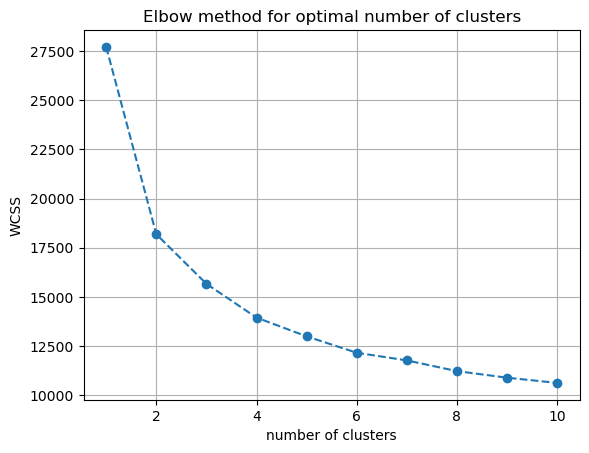

In [507]:
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow method for optimal number of clusters')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

- we are only getting 2 clusters.
    * if there are even a few number of amenities, it will classify that property to be luxury
    * if not then it is a budget property

- i wanted 3 clusters -> luxury, semi-luxury and budget

#### Second approach
- I first assigned a weight to each amenity/feature based on their luxury factor. 
- for example , if there's a lift then the weight will be 2, because it's very common but if there's a swimming pool or golf course, then the weight will be higher like 10 because it is luxurious
- Then , I'll add up the weight of all these features and assign a final luxury score to each property

In [509]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}

In [510]:
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [513]:
data['luxury_score'] = luxury_score

In [514]:
data[['features', 'luxury_score']][:10]

,features,luxury_score
0,NaN,0
1,"['Private Garden / Terrace', 'Maintenance Staff', 'Visitor Parking']",22
2,"['Power Back-up', 'Lift(s)', 'Swimming Pool', 'Fitness Centre / GYM', 'Club house / Community Center']",16
3,"['Feng Shui / Vaastu Compliant', 'Maintenance Staff', 'Water Storage', 'No open drainage around', 'Park', 'Visitor Parking', 'Security Personnel',...",49
4,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Piped-gas', 'Visi...",72
5,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor P...",49
6,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling...",160
7,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Water Stora...",96
8,"['Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'Separate entry for servant room', 'No open drainage around', 'Park', 'Vi...",80
9,NaN,0


In [518]:
# dropping 
data.drop(columns=['additionalRoom', 'nearbyLocations', 'furnishDetails', 'features', 'features_list'], inplace=True)

Index(['property_type', 'property_name', 'sector', 'society', 'price',
       'price_per_sqft', 'area', 'areaWithType', 'bedRoom', 'bathroom',
       'balcony', 'address', 'floorNum', 'facing', 'agePossession',
       'description', 'rating', 'super_built_up_area', 'built_up_area',
       'carpet_area', 'pooja room', 'store room', 'servant room', 'study room',
       'others', 'no exhaust fan', 'wardrobe', 'dining table',
       'no modular kitchen', 'tv', 'light', 'no washing machine', 'no fridge',
       'no water purifier', 'no ac', 'washing machine', 'water purifier',
       'no light', 'no wardrobe', 'no tv', 'fridge', 'no curtains', 'fan',
       'bed', 'no bed', 'modular kitchen', 'curtains', 'no chimney',
       'microwave', 'no fan', 'no sofa', 'no microwave', 'stove',
       'no dining table', 'exhaust fan', 'geyser', 'no stove', 'sofa',
       'no geyser', 'chimney', 'ac', 'furnishing_type', 'luxury_score'],
      dtype='object')

In [520]:
data.shape

(3974, 63)

In [521]:
data.columns

Index(['property_type', 'property_name', 'sector', 'society', 'price',
       'price_per_sqft', 'area', 'areaWithType', 'bedRoom', 'bathroom',
       'balcony', 'address', 'floorNum', 'facing', 'agePossession',
       'description', 'rating', 'super_built_up_area', 'built_up_area',
       'carpet_area', 'pooja room', 'store room', 'servant room', 'study room',
       'others', 'no exhaust fan', 'wardrobe', 'dining table',
       'no modular kitchen', 'tv', 'light', 'no washing machine', 'no fridge',
       'no water purifier', 'no ac', 'washing machine', 'water purifier',
       'no light', 'no wardrobe', 'no tv', 'fridge', 'no curtains', 'fan',
       'bed', 'no bed', 'modular kitchen', 'curtains', 'no chimney',
       'microwave', 'no fan', 'no sofa', 'no microwave', 'stove',
       'no dining table', 'exhaust fan', 'geyser', 'no stove', 'sofa',
       'no geyser', 'chimney', 'ac', 'furnishing_type', 'luxury_score'],
      dtype='object')

In [526]:
data = (data[['property_type', 'society', 'sector', 'price', 'price_per_sqft', 'area', 'areaWithType', 'bedRoom', 'bathroom', 'balcony', 'floorNum','facing', 'agePossession','super_built_up_area', 'built_up_area', 'carpet_area', 'pooja room', 'store room', 'servant room', 'study room','others', 'furnishing_type', 'luxury_score'
 ]])

In [527]:
data.shape

(3974, 23)

In [528]:
data.to_csv('gurgaon_properties_cleaned_v2.csv', index=False)